In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('Annomi_HuBERT.pkl')
df.head()

,mi_quality,transcript_id,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,annotator_id,...,reflection_exists,reflection_subtype,question_exists,question_subtype,main_therapist_behaviour,client_talk_type,client_audio_utterance,therapist_audio_utterance,client_hubert_emb,therapist_hubert_emb
0,high,0,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,thanks for filling it out we give this form to...,3,...,False,NaN,True,open,question,NaN,None,"[0.002105713, 0.0020751953, 0.0026245117, 0.00...",None,"[0.117147654, 0.3987467, 0.18795893, -0.138374..."
1,high,0,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,sure,3,...,NaN,NaN,NaN,NaN,NaN,neutral,"[0.0057373047, 0.0033569336, 0.0014648438, -0....",None,"[0.16314445, 0.33709005, 0.25657523, -0.106496...",None
2,high,0,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,so lets see it looks that you put you drink al...,3,...,False,NaN,False,NaN,therapist_input,NaN,None,"[0.0008239746, 0.003479004, 0.0008544922, -0.0...",None,"[0.1851178, 0.35557893, 0.19974922, -0.1263290..."
3,high,0,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,mmhmm,3,...,NaN,NaN,NaN,NaN,NaN,neutral,[],None,"[0.26716128, 0.33375242, 0.16871695, -0.183855...",None
4,high,0,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,and you usually have three to four drinks when...,3,...,False,NaN,False,NaN,therapist_input,NaN,None,"[0.0077819824, 0.008422852, 0.009338379, 0.010...",None,"[0.12812702, 0.33925486, 0.24788164, -0.148453..."


In [3]:
# Get a dataframe where interlocutor is cleint
df_client = df[df['interlocutor'] == 'client']

In [4]:
df_client.isnull().sum()

mi_quality                      0
transcript_id                   0
video_title                     0
video_url                       0
topic                           0
utterance_id                    0
interlocutor                    0
timestamp                       0
utterance_text                  0
annotator_id                    0
therapist_input_exists       6338
therapist_input_subtype      6338
reflection_exists            6338
reflection_subtype           6338
question_exists              6338
question_subtype             6338
main_therapist_behaviour     6338
client_talk_type                0
client_audio_utterance          0
therapist_audio_utterance    6338
client_hubert_emb               0
therapist_hubert_emb         6338
dtype: int64

# Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [6]:
# Split the df_therapist into train and test sets depending on the unique id of video_title
# The train set contains 80% of the data and the test set contains 20% of the data

video_titles = df_client['video_title'].unique()

train_video_titles, test_video_titles = train_test_split(video_titles, test_size=0.2, random_state=42)

train_df = df_client[df_client['video_title'].isin(train_video_titles)]
test_df = df_client[df_client['video_title'].isin(test_video_titles)]

In [7]:
# labeling the y_train and y_test
y_train_classes = train_df['client_talk_type']
le = preprocessing.LabelEncoder()
le.fit(y_train_classes)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y_train = le.transform(y_train_classes)
y_test_classes = test_df['client_talk_type']
y_test = le.transform(y_test_classes)

Original classes ['change' 'neutral' 'sustain']
Corresponding numeric classes [0 1 2]


In [8]:
# X_train and X_test

X_train = train_df['client_hubert_emb'].to_numpy()
X_test = test_df['client_hubert_emb'].to_numpy()

# Classification

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from transformers import HubertModel
from transformers import TrainingArguments, Trainer, AutoModel
from transformers import TrainerCallback, IntervalStrategy
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

2023-09-07 15:18:57.472088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 15:18:58.449890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.stack([torch.Tensor(i) for i in X_train]).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.stack([torch.Tensor(i) for i in X_test]).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class SimpleDNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

class ComplexModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ComplexModel, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.08)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.batch_norm4 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm4(self.fc4(x)))
        x = self.dropout(x)
        
        x = self.fc5(x)
        return x
    

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout_prob):
        super(LSTMModel, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout_prob, batch_first=True)

        # Define a dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Assuming x is of shape (batch_size, sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)
        
        # Use dropout for regularization
        out = self.dropout(lstm_out[:, -1, :])

        # Pass through the fully connected layer
        output = self.fc(out)

        return output



class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss



In [13]:
# Create an instance of the model and move it to device
num_classes = len(le.classes_)
# model = SimpleDNN(input_size=X_train_tensor.size(1), num_classes=num_classes).to(device)
model = LSTMModel(1024, 512, num_classes, 2, 0.1).to(device)


In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0000001)
criterion = FocalLoss(alpha=1, gamma=2)
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

best_val_f1 = 0.0

num_epochs = 100000
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    y_true_train, y_pred_train = [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(1) # Only needed for lstm
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = outputs.max(1)
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())

    train_f1 = f1_score(y_true_train, y_pred_train, average='macro')
    train_losses.append(train_loss / len(train_loader))
    train_f1_scores.append(train_f1)

    model.eval()
    val_loss = 0.0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1) # Only needed for lstm
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            y_true_val.extend(y_batch.cpu().numpy())
            y_pred_val.extend(predicted.cpu().numpy())

    val_f1 = f1_score(y_true_val, y_pred_val, average='macro')
    val_losses.append(val_loss / len(test_loader))
    val_f1_scores.append(val_f1)

    # Save the model if it has a better validation F1 score
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), 'best_model_hubert_client_state.pth')
        best_val_f1 = val_f1

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, '
            f'Train Loss: {train_losses[-1]:.4f}, Train F1: {train_f1:.4f}, '
            f'Validation Loss: {val_losses[-1]:.4f}, Validation F1: {val_f1:.4f}')



Epoch 100/100000, Train Loss: 0.3954, Train F1: 0.2601, Validation Loss: 0.4216, Validation F1: 0.2367
Epoch 200/100000, Train Loss: 0.3749, Train F1: 0.2601, Validation Loss: 0.4108, Validation F1: 0.2367
Epoch 300/100000, Train Loss: 0.3736, Train F1: 0.2601, Validation Loss: 0.4073, Validation F1: 0.2367
Epoch 400/100000, Train Loss: 0.3727, Train F1: 0.2601, Validation Loss: 0.4058, Validation F1: 0.2367
Epoch 500/100000, Train Loss: 0.3720, Train F1: 0.2601, Validation Loss: 0.4049, Validation F1: 0.2367
Epoch 600/100000, Train Loss: 0.3715, Train F1: 0.2601, Validation Loss: 0.4042, Validation F1: 0.2367
Epoch 700/100000, Train Loss: 0.3715, Train F1: 0.2601, Validation Loss: 0.4037, Validation F1: 0.2367
Epoch 800/100000, Train Loss: 0.3709, Train F1: 0.2601, Validation Loss: 0.4033, Validation F1: 0.2367
Epoch 900/100000, Train Loss: 0.3708, Train F1: 0.2601, Validation Loss: 0.4029, Validation F1: 0.2367
Epoch 1000/100000, Train Loss: 0.3701, Train F1: 0.2601, Validation Loss:

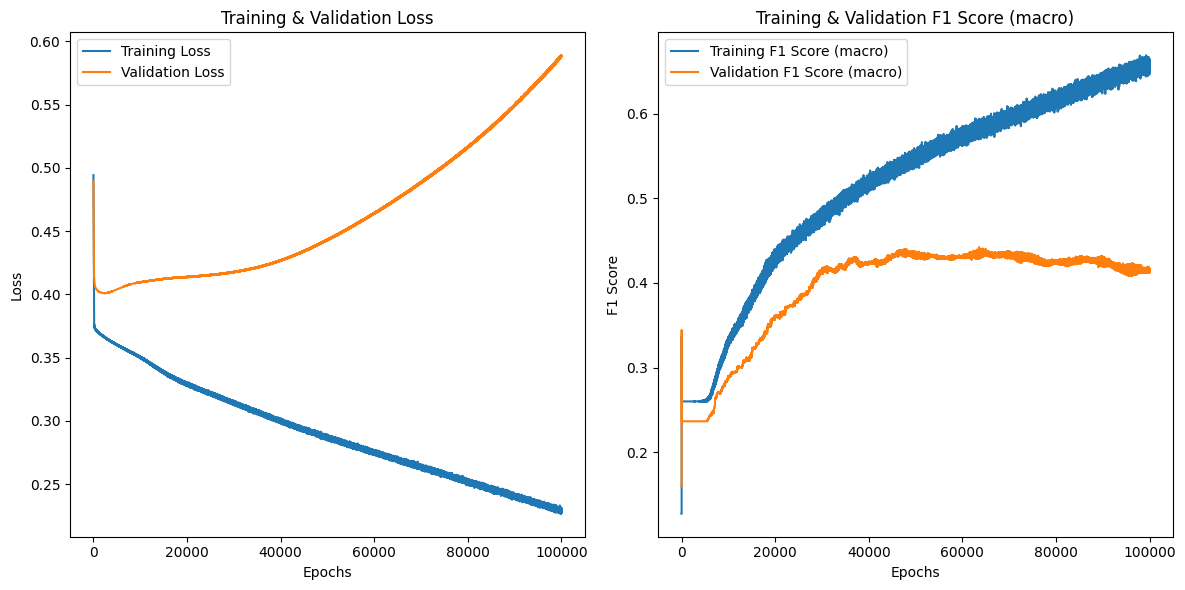

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Training F1 Score (macro)')
plt.plot(val_f1_scores, label='Validation F1 Score (macro)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training & Validation F1 Score (macro)')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Classification report
from sklearn.metrics import classification_report

y_pred = []
y_true = []

model.load_state_dict(torch.load('best_model_hubert_client_state.pth'))
model.eval()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(1) # Only needed for lstm
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_))


F1 Macro score of the model on the test data: 0.4139
